In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
test = pd.read_csv('../input/competition/test.csv')
train = pd.read_csv('../input/train-fe/train_fe.csv')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-fe/train_fe.csv
/kaggle/input/competition/train.csv
/kaggle/input/competition/test.csv


* domain knowledge -- different airline companies
* area codes are not related to geographic position
* find outliers
* standardize miles
* difference between test n train dataset
* clustering?
* are the features really correlated?

In [3]:
train.shape

(794860, 14)

In [4]:
train.head()

,Unnamed: 0,Unnamed: 0.1,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket,route
0,0,5,1,1,LAX,91,ORD,41,1744.0,2,1.0,AA,221.41,LAX-ORD
1,1,1328,1,1,MCO,33,ORD,41,1005.0,2,1.0,AA,159.64,MCO-ORD
2,2,5376,1,1,ORD,41,BOS,13,867.0,2,2.0,AA,184.62,BOS-ORD
3,3,5378,1,1,ORD,41,BOS,13,867.0,2,1.0,AA,198.60,BOS-ORD
4,4,5382,1,1,ORD,41,BOS,13,867.0,2,1.0,AA,255.89,BOS-ORD


In [5]:
train['MktCoupons'].value_counts()

1    790974
2      3886
Name: MktCoupons, dtype: int64

In [6]:
train['AirlineCompany'].value_counts()

UA    280806
DL    147862
AS     94750
AA     79704
WN     73671
B6     56731
NK     32759
F9     19286
VX      9291
Name: AirlineCompany, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='PricePerTicket'>

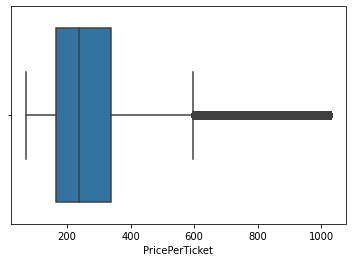

In [7]:
sns.boxplot(train['PricePerTicket'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Miles'>

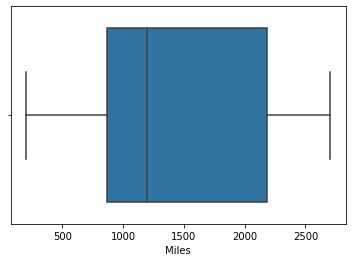

In [8]:
sns.boxplot(train['Miles'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Miles'>

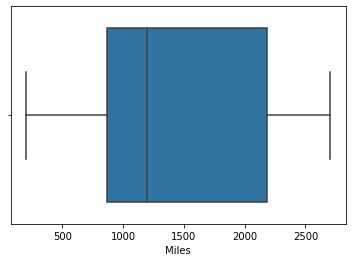

In [9]:
sns.boxplot(test['Miles'])

no outliers in miles column

<AxesSubplot:xlabel='Origin', ylabel='PricePerTicket'>

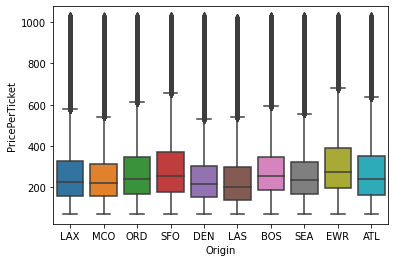

In [10]:
sns.boxplot(data = train, x= 'Origin', y = 'PricePerTicket')

In [11]:
#a LOT of outliers

<AxesSubplot:xlabel='AirlineCompany', ylabel='PricePerTicket'>

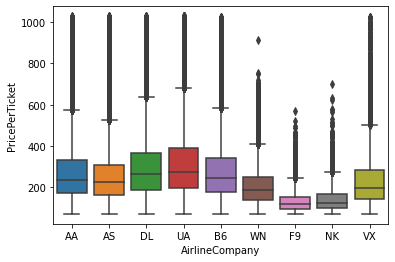

In [12]:
sns.boxplot(data = train, x= 'AirlineCompany', y = 'PricePerTicket')

<AxesSubplot:xlabel='MktCoupons', ylabel='PricePerTicket'>

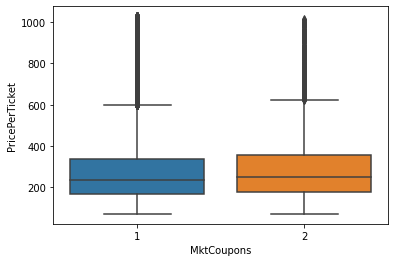

In [13]:
sns.boxplot(data = train, x= 'MktCoupons', y = 'PricePerTicket')

same with origin

<AxesSubplot:xlabel='MktCoupons', ylabel='PricePerTicket'>

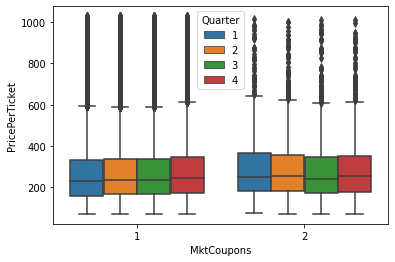

In [14]:
sns.boxplot(data = train, x= 'MktCoupons', y = 'PricePerTicket', hue='Quarter')
#but mutiplying makes it worse

can be grouped

In [15]:
train_c = train.copy()

In [16]:
# interaction effecct between quarter and num of tickets
t = pd.get_dummies(train['Quarter'], prefix="Quar")

# Multiply row-by-row
t = t.mul(train['NumTicketsOrdered'], axis=0)

# Join the new features to the feature set
train_c = train_c.join(t)

In [17]:
train['Origin'].unique()

array(['LAX', 'MCO', 'ORD', 'SFO', 'DEN', 'LAS', 'BOS', 'SEA', 'EWR',
       'ATL'], dtype=object)

In [18]:
#attempted to get more features from airport location, which turned out to be irrelevant
#airport = pd.read_csv('../input/airport/ICAO_airports.csv')

In [19]:
#airport

In [20]:
#airport = airport[airport['iata_code'].isin (train['Origin'].unique())]

In [22]:
#sns.scatterplot(data=airport, x = 'latitude_deg', y = 'longitude_deg', hue = 'Cluster')

In [23]:
'''
#attempted to do k means clustering which did not bring improvement 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
K = airport[['latitude_deg', 'longitude_deg']]
K["Cluster"] = kmeans.fit_predict(K)
K["Cluster"] = K["Cluster"].astype("category")

airport['Cluster']=K['Cluster']
'''

'\nfrom sklearn.cluster import KMeans\nkmeans = KMeans(n_clusters=4)\nK = airport[[\'latitude_deg\', \'longitude_deg\']]\nK["Cluster"] = kmeans.fit_predict(K)\nK["Cluster"] = K["Cluster"].astype("category")\n\nairport[\'Cluster\']=K[\'Cluster\']\n'

In [24]:
#d =dict(zip(airport['iata_code'], airport['Cluster']))
#d 

In [25]:
'''
d = {'ATL': 2,
 'BOS': 0,
 'DEN': 3,
 'EWR': 0,
 'LAS': 1,
 'LAX': 1,
 'MCO': 2,
 'ORD': 2,
 'SEA': 1,
 'SFO': 1}
 '''

"\nd = {'ATL': 2,\n 'BOS': 0,\n 'DEN': 3,\n 'EWR': 0,\n 'LAS': 1,\n 'LAX': 1,\n 'MCO': 2,\n 'ORD': 2,\n 'SEA': 1,\n 'SFO': 1}\n "

In [26]:
'''
train_c['o_area']=train_c['Origin'].map(d)
train_c['d_area']=train_c['Dest'].map(d)
'''

"\ntrain_c['o_area']=train_c['Origin'].map(d)\ntrain_c['d_area']=train_c['Dest'].map(d)\n"

In [27]:
'''
def comb(row):
    d=sorted([row['o_area'], row['d_area']])
    row['comb']= str(d[0]) + '-' + str(d[1])
    return row

train_c = train_c.apply(comb, axis='columns')
'''

"\ndef comb(row):\n    d=sorted([row['o_area'], row['d_area']])\n    row['comb']= str(d[0]) + '-' + str(d[1])\n    return row\n\ntrain_c = train_c.apply(comb, axis='columns')\n"

In [28]:
train['NumTicketsOrdered'].value_counts()

1.0     447189
2.0     119304
3.0      62244
4.0      39408
5.0      26949
6.0      19927
7.0      14825
8.0      11811
9.0       9534
10.0      7877
11.0      6660
12.0      5384
13.0      4640
14.0      3789
15.0      3455
16.0      2895
17.0      2571
18.0      2376
19.0      2149
20.0      1873
Name: NumTicketsOrdered, dtype: int64

<AxesSubplot:xlabel='Miles', ylabel='PricePerTicket'>

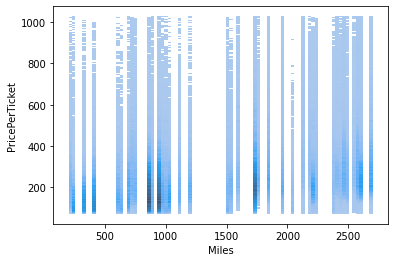

In [29]:
sns.histplot(data = train, x= 'Miles', y = 'PricePerTicket')

<AxesSubplot:xlabel='miles*', ylabel='PricePerTicket'>

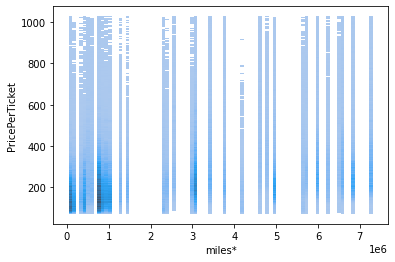

In [30]:
train_c['miles*'] = train_c['Miles']**2
sns.histplot(data = train_c, x= 'miles*', y = 'PricePerTicket')

* **expt**
* no strong correlation btw price and (*miles, quarter*, wac, *route, mkt*) 
* group : *numticketsordered,* origin 
* **sure**
* drop : ContiguousUSA, unamed

In [31]:
#combined the same routes e.g. A to B = B to A, which improved results
'''
def route(row):
    d=[]
    d.append(row['Origin'])
    d.append(row['Dest'])
    d.sort()
    row['route']= d[0] + '-' + d[1]
    return row

train = train.apply(route, axis='columns')
'''

"\ndef route(row):\n    d=[]\n    d.append(row['Origin'])\n    d.append(row['Dest'])\n    d.sort()\n    row['route']= d[0] + '-' + d[1]\n    return row\n\ntrain = train.apply(route, axis='columns')\n"

In [32]:
train

,Unnamed: 0,Unnamed: 0.1,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket,route
0,0,5,1,1,LAX,91,ORD,41,1744.0,2,1.0,AA,221.41,LAX-ORD
1,1,1328,1,1,MCO,33,ORD,41,1005.0,2,1.0,AA,159.64,MCO-ORD
2,2,5376,1,1,ORD,41,BOS,13,867.0,2,2.0,AA,184.62,BOS-ORD
3,3,5378,1,1,ORD,41,BOS,13,867.0,2,1.0,AA,198.60,BOS-ORD
4,4,5382,1,1,ORD,41,BOS,13,867.0,2,1.0,AA,255.89,BOS-ORD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794855,794855,9531828,1,4,LAS,85,LAX,91,236.0,2,1.0,WN,122.78,LAS-LAX
794856,794856,9531830,1,4,LAS,85,LAX,91,236.0,2,1.0,WN,122.29,LAS-LAX
794857,794857,9531832,1,4,LAS,85,LAX,91,236.0,2,1.0,WN,198.04,LAS-LAX
794858,794858,9533354,1,4,ATL,34,LAX,91,1947.0,2,1.0,WN,200.99,ATL-LAX


In [33]:

train['route'].unique()

array(['LAX-ORD', 'MCO-ORD', 'BOS-ORD', 'EWR-ORD', 'ORD-SFO', 'DEN-LAX',
       'LAS-LAX', 'LAX-MCO', 'DEN-ORD', 'LAS-ORD', 'ORD-SEA', 'ATL-LAX',
       'BOS-LAX', 'BOS-MCO', 'LAX-SEA', 'EWR-SFO', 'BOS-SFO', 'LAX-SFO',
       'DEN-SFO', 'LAS-SEA', 'DEN-SEA', 'EWR-SEA', 'ATL-LAS', 'ATL-SEA',
       'BOS-SEA', 'MCO-SEA', 'ATL-SFO', 'BOS-LAS', 'LAS-MCO', 'SEA-SFO',
       'ATL-ORD', 'ATL-BOS', 'ATL-EWR', 'ATL-MCO', 'ATL-DEN', 'EWR-MCO',
       'EWR-LAS', 'EWR-LAX', 'DEN-MCO', 'DEN-LAS', 'MCO-SFO', 'LAS-SFO',
       'BOS-EWR', 'BOS-DEN', 'DEN-EWR'], dtype=object)

<AxesSubplot:xlabel='route', ylabel='PricePerTicket'>

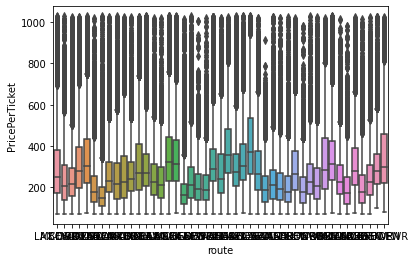

In [34]:
sns.boxplot(data = train_c, x= 'route', y = 'PricePerTicket')


In [35]:
train_c.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'MktCoupons', 'Quarter', 'Origin',
       'OriginWac', 'Dest', 'DestWac', 'Miles', 'ContiguousUSA',
       'NumTicketsOrdered', 'AirlineCompany', 'PricePerTicket', 'route',
       'Quar_1', 'Quar_2', 'Quar_3', 'Quar_4', 'miles*'],
      dtype='object')

In [36]:
train_c.isnull().any()

Unnamed: 0           False
Unnamed: 0.1         False
MktCoupons           False
Quarter              False
Origin               False
OriginWac            False
Dest                 False
DestWac              False
Miles                False
ContiguousUSA        False
NumTicketsOrdered    False
AirlineCompany       False
PricePerTicket       False
route                False
Quar_1               False
Quar_2               False
Quar_3               False
Quar_4               False
miles*               False
dtype: bool

no null values

In [37]:
train_c

,Unnamed: 0,Unnamed: 0.1,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket,route,Quar_1,Quar_2,Quar_3,Quar_4,miles*
0,0,5,1,1,LAX,91,ORD,41,1744.0,2,1.0,AA,221.41,LAX-ORD,1.0,0.0,0.0,0.0,3041536.0
1,1,1328,1,1,MCO,33,ORD,41,1005.0,2,1.0,AA,159.64,MCO-ORD,1.0,0.0,0.0,0.0,1010025.0
2,2,5376,1,1,ORD,41,BOS,13,867.0,2,2.0,AA,184.62,BOS-ORD,2.0,0.0,0.0,0.0,751689.0
3,3,5378,1,1,ORD,41,BOS,13,867.0,2,1.0,AA,198.60,BOS-ORD,1.0,0.0,0.0,0.0,751689.0
4,4,5382,1,1,ORD,41,BOS,13,867.0,2,1.0,AA,255.89,BOS-ORD,1.0,0.0,0.0,0.0,751689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794855,794855,9531828,1,4,LAS,85,LAX,91,236.0,2,1.0,WN,122.78,LAS-LAX,0.0,0.0,0.0,1.0,55696.0
794856,794856,9531830,1,4,LAS,85,LAX,91,236.0,2,1.0,WN,122.29,LAS-LAX,0.0,0.0,0.0,1.0,55696.0
794857,794857,9531832,1,4,LAS,85,LAX,91,236.0,2,1.0,WN,198.04,LAS-LAX,0.0,0.0,0.0,1.0,55696.0
794858,794858,9533354,1,4,ATL,34,LAX,91,1947.0,2,1.0,WN,200.99,ATL-LAX,0.0,0.0,0.0,1.0,3790809.0


In [38]:
train_c['NumTicketsOrdered'] = np.clip(train_c['NumTicketsOrdered'], a_min = 0, a_max = 10)

In [39]:
train_c['NumTicketsOrdered'].unique()

array([ 1.,  2.,  6.,  4.,  3., 10.,  5.,  9.,  8.,  7.])

In [40]:
y = train['PricePerTicket']
X = train_c[['Origin', 'Dest', 'AirlineCompany','NumTicketsOrdered', 'Miles', 'Quarter', 'MktCoupons', 'Quar_1', 'Quar_2', 'Quar_3', 'Quar_4', 'route']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [41]:
cat = ['Origin', 'Dest', 'AirlineCompany', 'Quarter', 'route']
num = ['NumTicketsOrdered', 'Miles', 'MktCoupons', 'Quar_1', 'Quar_2', 'Quar_3', 'Quar_4']

In [42]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler(feature_range=(0, 1))
oh = OneHotEncoder(handle_unknown='ignore')

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s, num),
        ('cat', oh, cat)
    ])

In [44]:
X1 = preprocessor.fit_transform(X)

In [45]:


n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
#num_leaves = [int(x) for x in np.linspace(start = 2, stop = 7, num = 3)]
#max_bin = [int(x) for x in np.linspace(start = 100, stop = 400, num = 3)]
learning_rate = [float(x) for x in np.linspace(start = 0.8, stop = 1.5, num = 3)]
grid= {'n_estimators': n_estimators,'learning_rate': learning_rate}


In [ ]:
#g_random.best_estimator_

In [71]:

model2 = XGBRegressor(n_estimators=400, learning_rate=0.1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model2', model2)
                             ])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['NumTicketsOrdered', 'Miles',
                                                   'MktCoupons', 'Quar_1',
                                                   'Quar_2', 'Quar_3', 'Quar_4',
                                                   'miles*']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Origin', 'Dest',
                                                   'AirlineCompany', 'Quarter',
                                                   'route'])])),
                ('model2',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              co...
                              enable_categorical=False, eval_metric=None,
                

In [72]:

final_pred = pipeline.predict(X_valid)
# Evaluate the model
score = mean_squared_error(y_valid, final_pred)
print('MAE:', score)

MAE: 17847.920467895245


* base: 17976.658081456033
* group tickets: 17974.28974672052
* miles: 17968.94638793009
* quarter : 17859.01914884888
* route: 17853.99337955956
* inter: 17767.25491601310 [2]

* model 1 : 17884.537217022553
* model 2: 17849

In [52]:
def route(row):
    d=sorted([row['Origin'], row['Dest']])
    row['route']= d[0] + '-' + d[1]
    return row

test = test.apply(route, axis='columns')

# deployment
* make route 
* interaction effect between quarter and num of tickets
* group num of tickets
* fit

In [73]:
test['miles*'] = test['Miles']**2

In [53]:
t = pd.get_dummies(test['Quarter'], prefix="Quar")

# Multiply row-by-row
t = t.mul(test['NumTicketsOrdered'], axis=0)

# Join the new features to the feature set
test = test.join(t)

In [54]:
test['NumTicketsOrdered'] = np.clip(test['NumTicketsOrdered'], a_min = 0, a_max = 10)

In [55]:
test= test[['Origin', 'Dest', 'AirlineCompany','NumTicketsOrdered', 'Miles', 'Quarter', 'MktCoupons', 'Quar_1', 'Quar_2', 'Quar_3', 'Quar_4', 'route']]

In [74]:
test

,Origin,Dest,AirlineCompany,NumTicketsOrdered,Miles,Quarter,MktCoupons,Quar_1,Quar_2,Quar_3,Quar_4,route,miles*
id,,,,,,,,,,,,,
0,LAX,EWR,AS,1.0,2454.0,3,1,0.0,0.0,1.0,0.0,EWR-LAX,6022116.0
1,SFO,LAS,UA,1.0,414.0,4,1,0.0,0.0,0.0,1.0,LAS-SFO,171396.0
2,EWR,ATL,DL,2.0,746.0,4,1,0.0,0.0,0.0,2.0,ATL-EWR,556516.0
3,ATL,LAX,AA,1.0,1947.0,3,1,0.0,0.0,1.0,0.0,ATL-LAX,3790809.0
4,ATL,SFO,DL,5.0,2139.0,3,1,0.0,0.0,5.0,0.0,ATL-SFO,4575321.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198710,ATL,LAS,DL,1.0,1747.0,1,1,1.0,0.0,0.0,0.0,ATL-LAS,3052009.0
198711,SEA,LAS,AS,1.0,867.0,3,1,0.0,0.0,1.0,0.0,LAS-SEA,751689.0
198712,ATL,LAS,DL,2.0,1747.0,3,1,0.0,0.0,2.0,0.0,ATL-LAS,3052009.0


In [75]:
pred_sub = pipeline.predict(test)

In [76]:
sub = pd.DataFrame(pred_sub, index = test.index)
sub.index.name="id"
sub.columns= ['PricePerTicket']
sub.to_csv('sub.csv')